__Лабораторная работа N1:__  метод частотного анализа для обработки текстов

__цель:__ изучить возможности частотного анализа в связке с  методами машинного обучения для обработки текстов

__порядок выполнения:__ собрать и разметить набор текстов, применить методы токенизации и очистки текста в различных вариантах, выполнить частотный анализ разными способами, использовать частотные характеристики текстов для решения задач определения темы текста и поиска близких текстов. 

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
# import matplotlib.pyplot as plt

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 
tqdm.pandas()

## данные

будем использовать тексты на русском языке,    
можно воспользоваться БД из примеров к лекциям  (data/news.pkl.gz)   
или собрать свой датасет

In [2]:
# загружаем тексты
data = pd.read_pickle('../data/news.pkl.gz')
print('записей:',len(data))
data.sample(5)

записей: 3196


text  \
694   15 лет строгого режима получил житель Кобрина, который ввел знакомому смертельную дозу наркотика\n\n9 декабря 2016 в 16:13\n\nTUT.BY\n\n8 декабря в Кобрине огласили приговор 41-летнему мужчине, ко...   
2116  МОСКВА, 13 декабря. /ТАСС/. "Вильярреал" крупно победил мадридский "Атлетико" в домашнем матче 15-го тура чемпионата Испании по футболу. Встреча завершилась со счетом 3:0.\n\nМячи забили Мануэль Т...   
1609  В Алеппо за сутки более 350 боевиков сложили оружие\n\nМОСКВА, 13 дек — РИА Новости. В восточной части Алеппо за сутки сложили оружие 375 боевиков; все они вышли в западные районы города, которые ...   
2039  Алексей Емелин разбавил скучный матч своими силовыми приемами, Александр Радулов проиграл единоборство в овертайме, а Владислав Каменев набрал три очка в АХЛ.\n\n"ПИТТСБУРГ" – "АРИЗОНА" – 7:0\n\nЕ...   
2145  12 декабря 2016 в 21.00 (МСК) начнется матч 16 тура чемпионата Италии, в котором Фиорентина на своем поле будет принимать Сассуоло. Эксперт Footballtips Ведран Остоич делится с нами своим прогнозо...   

           tag  
694   incident  
2116     sport  
1609  politics  
2039     sport  
2145     sport

## Очистка и токенизация

произвести токенизацию и очистку текстов для ЧА   

In [3]:
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize as nltk_tokenize_word
from nltk.tokenize import sent_tokenize as nltk_tokenize_sent

from nltk.corpus import stopwords as nltk_stopwords
# from nltk import download as nltk_download
# nltk_download('stopwords')
# nltk_download('punkt')

для каждого варианта очистки текста построить словарь,   
оценить корректность результата (неформально)

In [4]:
# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def string_normalizer(s):
    pat = [
       [r'ё','е'] # замена ё для унификации
       ,[r'</?[a-z]+>',' '] # удаляем xml
       ,[r'[^a-zа-я\- ]+',' '] # оставляем только буквы, пробел и -
       ,[r' -\w+',' '] # удаляем '-й','-тый' и т.п.
       ,[r'\w+- ',' ']
       ,[r' +',' '] # удаляем повторы пробелов
    ]
    return replace_patterns(s.lower(),pat).strip()

In [5]:
data['ctext'] = data['text'].progress_apply(string_normalizer)

  0%|          | 0/3196 [00:00<?, ?it/s]

100%|██████████| 3196/3196 [00:00<00:00, 4602.72it/s]


In [6]:
data.sample(3)

text  \
2607  Кресло сдавливает некоторые нервы в области шеи\n\nВладивосток, вторник, 13 декабря , РИА Vladnews.\n\nАмериканские ученые выяснили, что мытье головы в салонах красоты может стать причиной появлен...   
3005  Новостному российскому интернет порталупередана информация, что спортивная модификация хэтчбека, от базовой вариации модели будет отличаться новым обвесом, черными колесными дисками, фарами, радиа...   
1780  Промышленное производство в Китае выше прогноза\n\nСогласно данным, опубликованным сегодня Национальным бюро статистики Китая, промышленное производство в Поднебесной увеличилось в ноябре, в годов...   

            tag  \
2607    science   
3005       auto   
1780  economics   

                                                                                                                                                                                                        ctext  
2607  кресло сдавливает некоторые нервы в области шеи владивосток вторник декабря риа vladnews американские ученые выяснили что мытье головы в салонах красоты может стать причиной появление инсульта соо...  
3005  новостному российскому интернет порталупередана информация что спортивная модификация хэтчбека от базовой вариации модели будет отличаться новым обвесом черными колесными дисками фарами радиаторно...  
1780  промышленное производство в китае выше прогноза согласно данным опубликованным сегодня национальным бюро статистики китая промышленное производство в поднебесной увеличилось в ноябре в годовом исч...

In [7]:
words = sorted(
    [
        nltk_tokenize_word(sent, language='russian') for sent in tqdm(list(data.ctext))
    ]
)
words

100%|██████████| 3196/3196 [00:02<00:00, 1542.99it/s]


[['-',
  '-',
  'аналитики',
  'российского',
  'рынка',
  'автопродаж',
  'составили',
  'список',
  'самых',
  'популярных',
  'в',
  'рф',
  'автомобилей',
  'с',
  'автоматическими',
  'трансмиссиями',
  'агентство',
  'автостат',
  'его',
  'обнародовало',
  'как',
  'оказалось',
  'за',
  'январь-ноябрь',
  'года',
  'самым',
  'популярным',
  'авто',
  'с',
  'коробкой-автомат',
  'стала',
  'у',
  'российских',
  'автолюбителей',
  'toyota',
  'camry',
  'от',
  'нее',
  'ненамного',
  'отстают',
  'модели',
  'южнокорейских',
  'производителей',
  'kia',
  'rio',
  'и',
  'hyundai',
  'solaris',
  'их',
  'объединяет',
  'единая',
  'платформа',
  'положенная',
  'в',
  'основу',
  'у',
  'этих',
  'моделей',
  'доля',
  'реализованных',
  'экземпляров',
  'с',
  'акпп',
  'превышает',
  'и',
  'соответственно',
  'четвертое',
  'место',
  'рейтинга',
  'занимает',
  'volkswagen',
  'polo',
  'sedan',
  'хотя',
  'на',
  'сегодняшний',
  'день',
  'немецкий',
  'автопроизводит

## Частотный анализ 

на очищенных текстах выполнить частотный анализ различными способами
- простой подсчёт повторов слов
- простой подсчёт повторов слов с нормализацией
- простой подсчёт повторов слов с нормализацией и обратной частотой

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from razdel import tokenize
from nltk.corpus import stopwords as nltk_stopwords

In [9]:

stopwords = set(nltk_stopwords.words('russian'))

def tokenizer(text,stopwords=stopwords):
    return [
            t.text for t in tokenize( # разбиваем текст на слова
                re.sub(r'</?[a-z]+>',' ',text), # удаляем xml tag 
            ) 
            if not (
               False
               or (t.text in stopwords) # выкидываем предлоги, союзы и т.п.    
               or re.match(r'^[^a-zA-ZЁёА-я]+$', t.text) # выкидываем токены не содержащие букв
               or re.match(r'^(\w)\1+$', t.text)  # выкидываем токены из одного повторяющегося символа
               or re.match(r'^[^a-zA-ZЁёА-я].*$', t.text)  # выкидываем токены начинающиеся не с буквы
            )
        ] 

In [10]:
# использования токенайзера вместе с векторайзером
tf_model = TfidfVectorizer(
        min_df=.001, # выкидываем очень редкие слова
        max_df=.10, # выкидываем очень частые слова
        use_idf=False, # не используем обратную частоту
        norm='l2', # нормируем TF
        tokenizer=tokenizer, # ф-ция токенайзер
        token_pattern=None, # отключаем дефолтный токенайзер
    )

data_tf = tf_model.fit_transform( data['text'] )

In [11]:
data_tf.shape

(3196, 19991)

In [12]:
vcb1 = sorted(tf_model.vocabulary_)
print(len(vcb1))
pd.Series(vcb1).sample(30)

19991


8291            мозыря
18720           фидель
3103          геминиды
19026           ходить
9691        обращается
10824          офисные
1497            бориса
5501          значится
4882        заводского
12249         помешает
1719          валютные
1917             весна
17007         стороной
16456    соревноваться
18176           узнать
6614        колеблется
5705           израиле
575            автобус
17874             трое
5756             имеют
6255             камня
519                xix
3720          дежурила
11864         поединки
6960          короткое
3641                дв
10523        отвлекать
2452           ворачек
12816         практика
16401        сообщению
dtype: object

## поиск похожих текстов

применить методы кластеризации для разных вариантов расчёта частотной характеристики,    
оценить результат т.е. степень схожести текстов в кластерах (неформально)

In [13]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [14]:
from sklearn.metrics.pairwise import euclidean_distances
d = euclidean_distances(data_tf)
display( d[d>0.].min(),d[d>0.].mean(),d.max(), )

0.048607310578585305

1.4043391516221135

1.4142135623731027

In [15]:
data['cluster_id'] = DBSCAN(eps=.7,min_samples=3).fit(data_tf).labels_
data['cluster_id'].drop_duplicates().count()

21

In [16]:
cluster_descr = pd.concat([
        data[['cluster_id','tag']].groupby(['cluster_id'])['tag'].count(),
        data[['cluster_id','tag']].groupby(['cluster_id'])['tag'].apply(lambda s: set(s)).apply(' '.join)
    ],axis=1).reset_index()

cluster_descr.columns = ['cluster_id','count','tags']

display( cluster_descr )

cluster_id  count  \
0           -1   3128   
1            0      3   
2            1      5   
3            2      3   
4            3      4   
5            4      4   
6            5      5   
7            6      3   
8            7      3   
9            8      3   
10           9      3   
11          10      3   
12          11      3   
13          12      3   
14          13      3   
15          14      3   
16          15      3   
17          16      4   
18          17      3   
19          18      4   
20          19      3   

                                                                                              tags  
0   politics woman science realty economics auto sport health tech reclama culture social incident  
1                                                                                        economics  
2                                                                                         politics  
3                                                                                         politics  
4                                                                                         politics  
5                                                                                         politics  
6                                                                                          culture  
7                                                                                            sport  
8                                                                                          science  
9                                                                                         incident  
10                                                                                           sport  
11                                                                                        incident  
12                                                                                         culture  
13                                                                                          social  
14                                                                                          social  
15                                                                                          social  
16                                                                                          health  
17                                                                                        incident  
18                                                                                         culture  
19                                                                                 social politics  
20                                                                                          social

In [17]:
display( data.query('cluster_id==15') )

text  \
3082  Губернаторы.Ru- информационный портал (governors.ru) Бесплатное\nзубопротезирование 645 жителям Камчатского края с начала 2010 года оказаны\nуслуги по бесплатному зубопротезированию на сумму 11 мл...   
3092  Север ДВ (severdv.ru) Более 600 камчатцев обрели новые зубные протезы 645\nжителям Камчатского края с начала 2010 года оказаны услуги по бесплатному\nзубопротезированию на сумму 11,6 млн. руб.  На...   
3128  Вечерние Вести Петропавловска Сотням жителям Камчатки бесплатно вставили\nзубы 645 жителям Камчатского края с начала 2010 года оказаны услуги по\nбесплатному зубопротезированию на сумму 11 млн. 60...   

         tag  \
3082  health   
3092  health   
3128  health   

                                                                                                                                                                                                        ctext  \
3082  губернаторы информационный портал governors ru бесплатное зубопротезирование жителям камчатского края с начала года оказаны услуги по бесплатному зубопротезированию на сумму млн тыс руб об этом со...   
3092  север дв severdv ru более камчатцев обрели новые зубные протезы жителям камчатского края с начала года оказаны услуги по бесплатному зубопротезированию на сумму млн руб на эти цели было выделено м...   
3128  вечерние вести петропавловска сотням жителям камчатки бесплатно вставили зубы жителям камчатского края с начала года оказаны услуги по бесплатному зубопротезированию на сумму млн тыс руб об этом с...   

      cluster_id  
3082          15  
3092          15  
3128          15

## классификатор текстов

тексты размечены, т.е. тексты имеют метку темы

построить классификатор на размеченных текстах,   
- построить датасет, 
- разделить на учебные и тестовые 

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
labels = { t:i for i,t in enumerate(sorted(set(data['tag']))) }
labels

{'auto': 0,
 'culture': 1,
 'economics': 2,
 'health': 3,
 'incident': 4,
 'politics': 5,
 'realty': 6,
 'reclama': 7,
 'science': 8,
 'social': 9,
 'sport': 10,
 'tech': 11,
 'woman': 12}

In [20]:
y = data['tag'].map(labels).values
y

array([5, 1, 1, ..., 8, 5, 9], dtype=int64)

In [21]:
X_train, X_test, y_train, y_test = train_test_split( data_tf, y, test_size=0.3, random_state=326 )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2237, 19991), (2237,), (959, 19991), (959,))

- обучить классификатор

In [22]:
from sklearn.linear_model import SGDClassifier

In [23]:
clf = SGDClassifier(loss='hinge',max_iter=1000, tol=0.19).fit(X_train,y_train)

- протестировать и оценить результаты с помощью формальных оценок

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [25]:
# доля правильных ответов на учебном наборе
o = clf.predict(X_train)
accuracy_score(y_train,o)

0.9991059454626732

In [26]:
# доля правильных ответов на тестовом наборе
o = clf.predict(X_test)

accuracy_score(y_test,o)

0.8686131386861314

In [27]:
print( classification_report( y_test, o, target_names=sorted(labels.keys()) ) )

              precision    recall  f1-score   support

        auto       0.96      0.86      0.91        87
     culture       0.75      0.93      0.83       101
   economics       0.82      0.83      0.82        76
      health       0.79      0.71      0.75        31
    incident       0.90      0.92      0.91       123
    politics       0.87      0.94      0.91       177
      realty       0.89      0.76      0.82        21
     reclama       1.00      0.71      0.83        17
     science       0.91      1.00      0.95        68
      social       0.65      0.34      0.45        44
       sport       0.99      0.98      0.99       118
        tech       0.81      0.75      0.78        89
       woman       0.83      0.71      0.77         7

    accuracy                           0.87       959
   macro avg       0.86      0.80      0.82       959
weighted avg       0.87      0.87      0.86       959



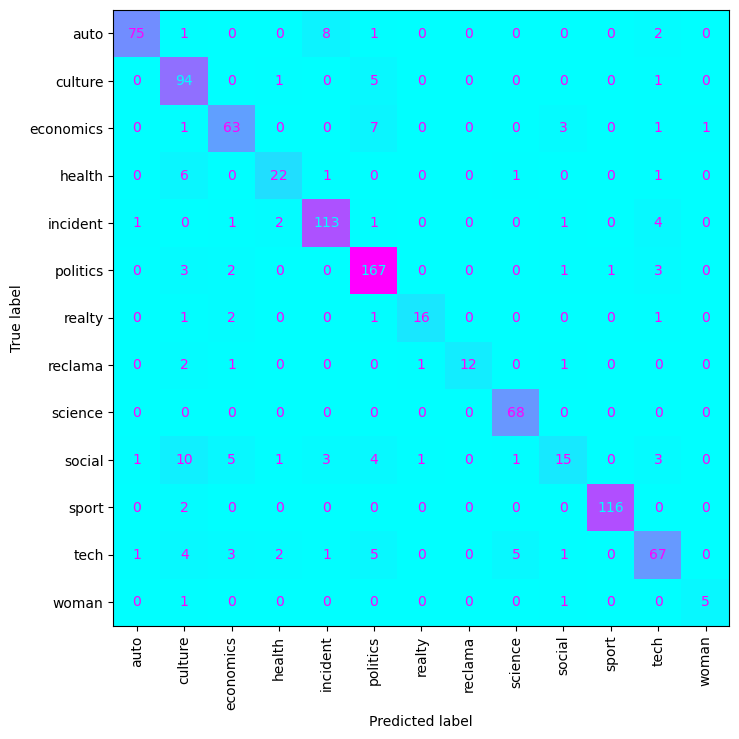

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

fig,ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test,o), 
    display_labels=sorted(labels.keys()),
)
disp.plot(ax=ax, xticks_rotation='vertical', include_values=True, cmap='cool',  colorbar=False,)
plt.show()

In [29]:
data['predict'] = pd.Series( clf.predict(data_tf) ).map( { labels[k]:k for k in labels } )

In [30]:
data.query('tag!=predict')

text  \
0     В Саудовской Аравии сняли первый антитеррористический мультфильм -\nтрехминутную ленту "Внимание!". "Внимание!" отражает точку зрения мирового\nсообщества на войну, развязанную терроризмом, и поэт...   
39    Баскетбол : Кириленко опроверг прогнозы врачей Главная звезда российского\nбаскетбола Андрей Кириленко вернулся в строй после двухнедельного\nотсутствия, связанного с травмой правой лодыжки. О том...   
56    Боль в груди? А ты поди - роди! Поэтому мы решили помочь мамам восстановиться\nсамим и научиться ухаживать за новорожденным.Роддома отличаются очень\nжесткими кроватями, которые "удваивают" ощущения.   
79                                                                                                                                    Вышла финальная версия Firefox 1.5 Анонсирован выход релиза Firefox 1.5   
86    Устанавливаем Solaris 10 в VMware Workstation 5.5В PDF документе " How\nto Install Solaris 10 Inside VMware Workstation 5.5 " (размер 500Кб) по\nшагам и со скриншотами описан процесс конфигурирова...   
...                                                                                                                                                                                                       ...   
3157  28.07.2010. ИТАР-ТАСС - Программа ВОСТОК На Колыме успешно завершился\nэтнокультурный образовательныйэксперимент по программе поддержки северных\nнародов Губернские ведомости (Южно-Сахалинск) Севе...   
3158  Центр рыночной информации АПК Закон об охоте, учитывающий интересы коренных\nмалочисленных народов Севера, вступит в силу с 1 января 2011 года Проект\nфедерального закона "О внесении изменений в Ф...   
3169  22.07.2010. Телекомпания "Северный город" Закон об охоте, учитывающий\nинтересы КМНС, вступит в силу с 1 январябудущего года.  URA.RU - Российское\nинформационное агентство Задание Комаровой выпол...   
3173  Все новости Красноярска (Yarsk.Ru) Финансирование программы ?Коренные\nмалочисленные народы Севера? увеличится на 7 миллионов рублей 15 июля\nсостоялось заседание Правительства Красноярского края,...   
3192  Интерфакс Религия (interfax-religion.ru) В Минрегионразвития призывают\nроссиян не бояться своего духовного наследия подобно Европе В министерстве\nрегионального развития РФ считают крайне важным ...   

            tag  \
0      politics   
39        sport   
56       health   
79         tech   
86         tech   
...         ...   
3157     social   
3158     social   
3169   politics   
3173  economics   
3192     social   

                                                                                                                                                                                                        ctext  \
0     в саудовской аравии сняли первый антитеррористический мультфильм - трехминутную ленту внимание внимание отражает точку зрения мирового сообщества на войну развязанную терроризмом и поэтому понятен...   
39    баскетбол кириленко опроверг прогнозы врачей главная звезда российского баскетбола андрей кириленко вернулся в строй после двухнедельного отсутствия связанного с травмой правой лодыжки о том как с...   
56            боль в груди а ты поди - роди поэтому мы решили помочь мамам восстановиться самим и научиться ухаживать за новорожденным роддома отличаются очень жесткими кроватями которые удваивают ощущения   
79                                                                                                                                            вышла финальная версия firefox анонсирован выход релиза firefox   
86    устанавливаем solaris в vmware workstation в pdf документе how to install solaris inside vmware workstation размер кб по шагам и со скриншотами описан процесс конфигурирования vmwake для запуска s...   
...                                                                                                                                                                                                       ...   


## тематическое моделирование

применить методы разложения частотной матрицы    
для разделения текстов по темам

[ слова x документы ] = [ слова х темы ] * [ темы х документы ]

http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

оценить результаты (неформально)

In [31]:
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

tf_feature_names = tf_model.get_feature_names_out()

In [32]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.tight_layout()
    plt.show()

In [33]:
lda = LatentDirichletAllocation(
    n_components=10, 
    max_iter=5,
    learning_method='online',
    learning_offset=50.,
    random_state=0
)

nmf = NMF(
    n_components=10,
    random_state=1,
    init="nndsvda",
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
)

In [34]:
lda.fit(data_tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=0)

In [35]:
nmf.fit(data_tf)

NMF(alpha_H=5e-05, alpha_W=5e-05, beta_loss='kullback-leibler', init='nndsvda',
    l1_ratio=0.5, max_iter=1000, n_components=10, random_state=1, solver='mu')

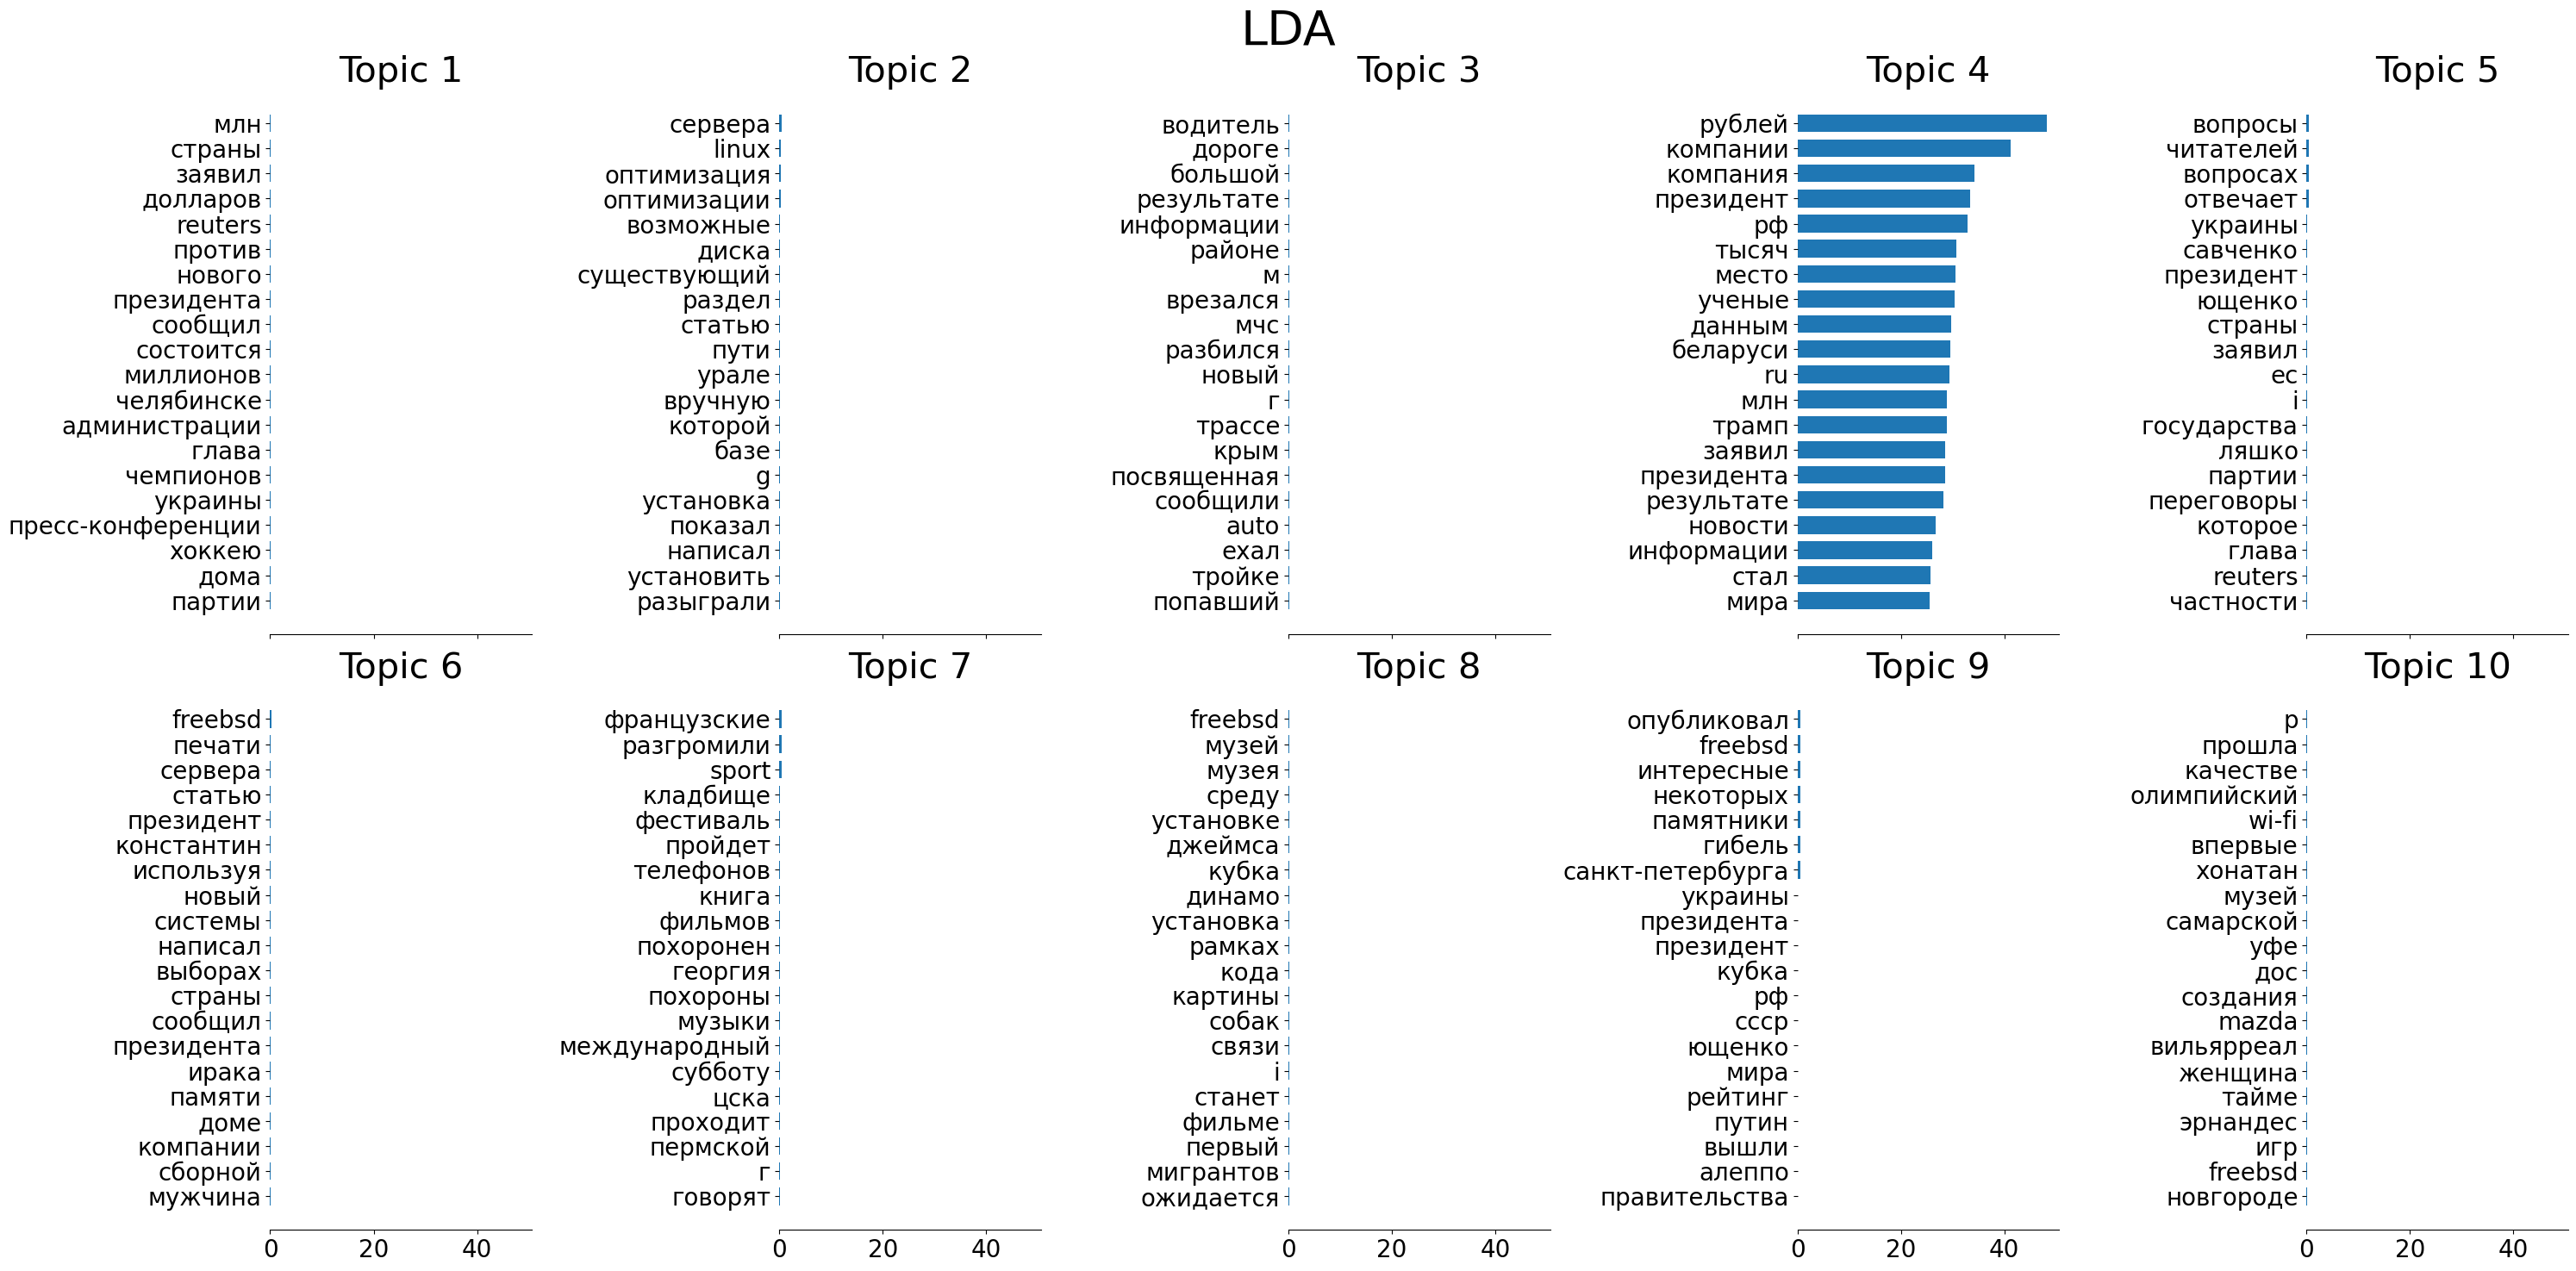

In [36]:
plot_top_words(lda, tf_feature_names, 20, "LDA")

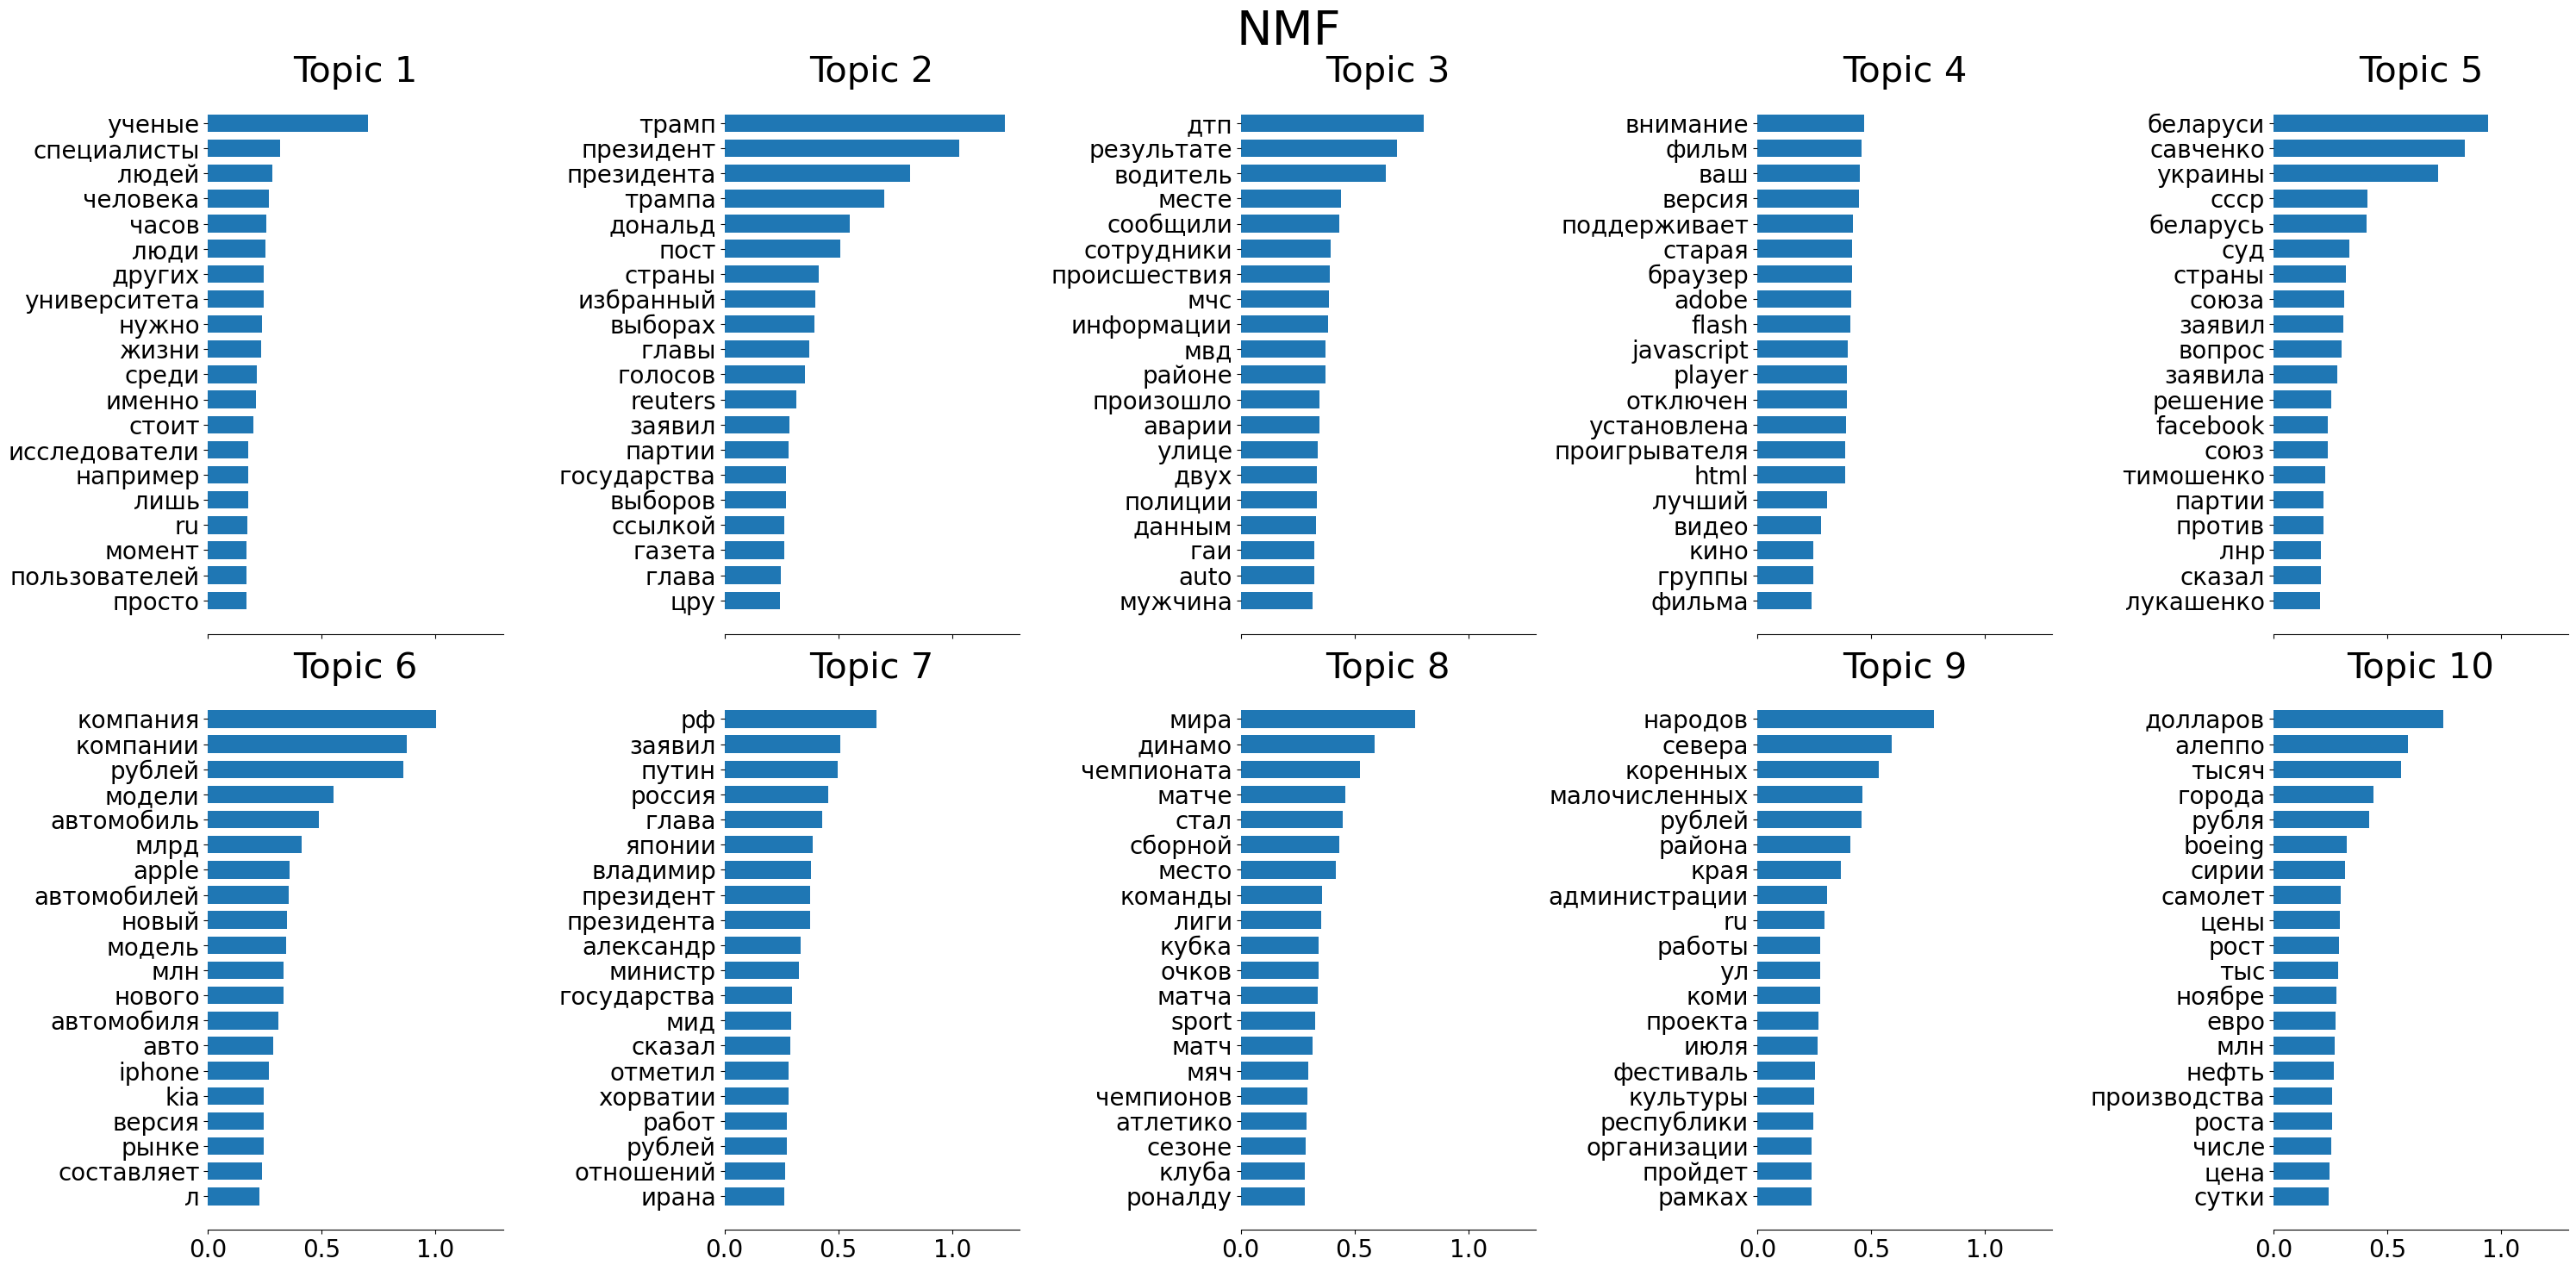

In [37]:
plot_top_words(nmf, tf_feature_names, 20, "NMF")